In [60]:
import requests
import json
import pandas as pd
import pyspark.sql.functions as sql
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from bs4 import BeautifulSoup

# Scraping web data

We will be scraping data regarding pc RAM from Corsairs official website and storing it in a Spark DataFrame for transformation - then visualising this scraped data using matplotlib.

First we define the URL that the data resides in, then make a request to the website to recieve the HTML content of the website and finally use BeautifulSoup to parse this HTML content and extract the data we wish to store.

In [3]:
URL = "https://www.corsair.com/uk/en/Categories/Products/Memory/c/Cor_Products_Memory"
request = requests.get(URL)
content = request.content
soup = BeautifulSoup(content, 'lxml') #using 'lxml' parser to parse HTML content

Once we have created our HTML parser and saved the HTML content of the website we wish to scrape, we will now extract the data by referencing HTML tags where the information is contained

In [55]:
title_html = soup.find_all('div', class_="product-item")
titles = [i.a['title'] for i in title_html] #access 'a' tag and retrieves 'title' attribute that stores product titles
price_html = soup.find_all('div', class_="price")
prices = [i.text for i in price_html]
prices = prices[:12] #takes first 12 entries of prices that correspond to first 12 titles returned from title HTML
prices = [i.replace('\n', '') for i in prices] #removes newline characters
prices = [i.replace('\t', '') for i in prices]
prices = [i.replace('\r', '') for i in prices]

data = [{'product': i, 'price': j} for i, j in zip(titles, prices)]

Next we will load the scraped data into a Spark DataFrame and begin transformation. Currently, the price is being recorded as a string due to the currency symbol - we will replace this with a float so it can be plotted on our graph.

In [68]:
spark = SparkSession.builder.appName('webscraping').getOrCreate()
schema = "product STRING, price STRING"
df = spark.createDataFrame(data, schema = schema) #loading data into DataFrame

df = df.select('product', sql.regexp_replace(df.price, '£', '').alias('price')) #removing '£' symbol from price
df = df.select('product', df.price.cast(FloatType()).alias('price')) #casting price column to float
df.show()

+--------------------+------+
|             product| price|
+--------------------+------+
|VENGEANCE® RGB PR...|249.99|
|VENGEANCE® LPX 16...|529.99|
|CORSAIR Memory — ...|629.99|
|CORSAIR Memory — ...|229.99|
|VENGEANCE® LPX 8G...|159.99|
|Corsair Mac Memor...|164.99|
|CORSAIR Memory — ...|559.99|
|CORSAIR Memory — ...|529.99|
|CORSAIR Memory — ...| 54.99|
|VENGEANCE® LPX 16...| 89.99|
|Corsair Memory 8G...|129.99|
|Corsair Memory — ...| 89.99|
+--------------------+------+



Now that we have transformed our dataset and casted the price column to a float datatype, we can create a barchart to visualise the prices of each product. To do this, we will convert the Spark DataFrame to a Pandas DataFrame using Spark's .toPandas() method so that we can access to columns of the dataset directly when plotting our graph

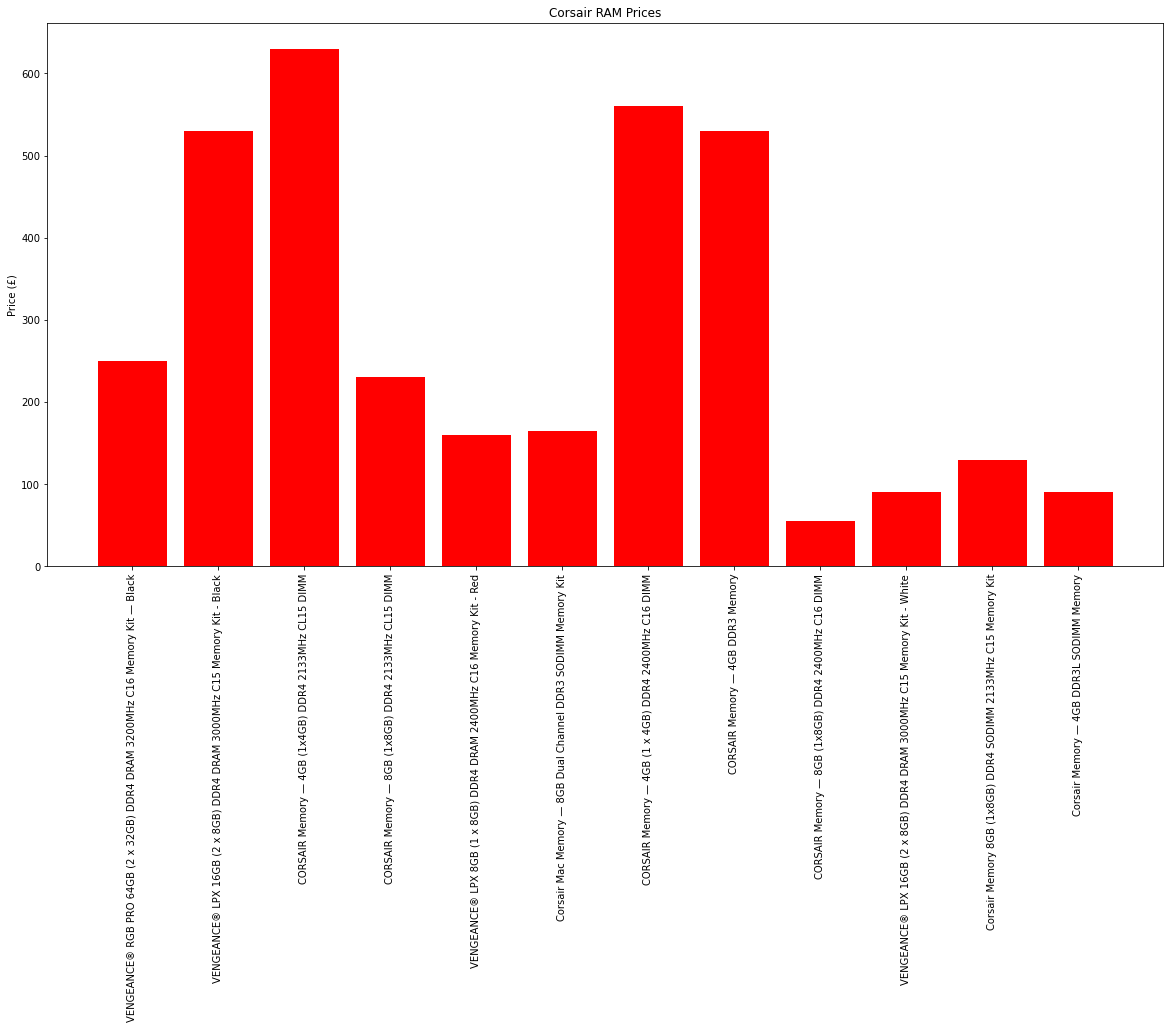

In [69]:
df = df.toPandas() #converts Spark DataFrame to Pandas
plt.figure(figsize = (20,10))
plt.title("Corsair RAM Prices")
plt.bar(df['product'], df['price'], color = 'red')
plt.xticks(rotation = 90) #rotates x axis 90 degrees
plt.ylabel("Price (£)")
plt.show() #displays figure 

# Summary

In this notebook, we scraped data regarding Corsair RAM from their official website and performed transformations on the data so that we could visualise it using Matplotlib. 